# Make MTH5 from IRIS Data Managment Center v0.2.0 

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

In [54]:
from pathlib import Path

import pandas as pd
from mth5.mth5 import MTH5
from mth5.clients.make_mth5 import MakeMTH5

from matplotlib import pyplot as plt
%matplotlib widget

## Set the path to save files to as the current working directory

In [2]:
default_path = Path().cwd()

## Initialize a MakeMTH5 object

Here, we are setting the MTH5 file version to 0.2.0 so that we can have multiple surveys in a single file.  Also, setting the client to "IRIS".  Here, we are using `obspy.clients` tools for the request.  Here are the available [FDSN clients](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

**Note:** Only the "IRIS" client has been tested.

In [3]:
m = MakeMTH5(mth5_version='0.2.0')
m.client = "IRIS"

## Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

In [7]:
#EMCAY10LFE = ['EM', 'CAY10', '', 'LFE', '2019-10-07T00:00:00', '2019-10-30T00:00:00'] 
#EMCAY10LFN = ['EM', 'CAY10', '', 'LFN', '2019-10-07T00:00:00', '2019-10-30T00:00:00'] 
#EMCAY10LFZ = ['EM', 'CAY10', '', 'LFZ', '2019-10-07T00:00:00', '2019-10-30T00:00:00'] 
#EMCAY10LQE = ['EM', 'CAY10', '', 'LQE', '2019-10-07T00:00:00', '2019-10-30T00:00:00'] 
#EMCAY10LQN = ['EM', 'CAY10', '', 'LQN', '2019-10-07T00:00:00', '2019-10-30T00:00:00'] 
ZUCAS04LQ1 = ['8P', 'CAS04', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04LQ2 = ['8P', 'CAS04', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04BF1 = ['8P', 'CAS04', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04BF2 = ['8P', 'CAS04', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUCAS04BF3 = ['8P', 'CAS04', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUNRV08LQ1 = ['8P', 'NVR08', '', 'LQE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUNRV08LQ2 = ['8P', 'NVR08', '', 'LQN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUNRV08BF1 = ['8P', 'NVR08', '', 'LFE', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUNRV08BF2 = ['8P', 'NVR08', '', 'LFN', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
ZUNRV08BF3 = ['8P', 'NVR08', '', 'LFZ', '2020-06-02T19:00:00', '2020-07-13T19:00:00']
request_list = [
    #EMCAY10LFE, EMCAY10LFN, EMCAY10LFZ, EMCAY10LQE, EMCAY10LQN,
    ZUCAS04LQ1, ZUCAS04LQ2, ZUCAS04BF1, ZUCAS04BF2, ZUCAS04BF3,
    ZUNRV08LQ1, ZUNRV08LQ2, ZUNRV08BF1, ZUNRV08BF2, ZUNRV08BF3
]

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=m.column_names)
request_df

,network,station,location,channel,start,end
0,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
5,8P,NVR08,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
6,8P,NVR08,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
7,8P,NVR08,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
8,8P,NVR08,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
9,8P,NVR08,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00


## Save the request as a CSV

Its helpful to be able to save the request as a CSV and modify it and use it later.  A CSV can be input as a request to `MakeMTH5`

In [8]:
request_df.to_csv(default_path.joinpath("fdsn_request.csv"))

## Get only the metadata from IRIS

It can be helpful to make sure that your request is what you would expect.  For that you can request only the metadata from IRIS.  The request is quick and light so shouldn't need to worry about the speed.  

In [9]:
inventory, data = m.get_inventory_from_df(request_df, data=False)

Have a look at the Inventory to make sure it contains what is requested.

In [10]:
inventory

Inventory created at 2022-04-12T23:04:28.609255Z
	Created by: ObsPy 1.2.2
		    https://www.obspy.org
	Sending institution: MTH5
	Contains:
		Networks (1):
			8P
		Stations (2):
			8P.CAS04 (Corral Hollow, CA, USA)
			8P.NVR08 (Rhodes Salt Marsh, NV, USA)
		Channels (10):
			8P.CAS04..LFZ, 8P.CAS04..LFN, 8P.CAS04..LFE, 8P.CAS04..LQN, 
			8P.CAS04..LQE, 8P.NVR08..LFZ, 8P.NVR08..LFN, 8P.NVR08..LFE, 
			8P.NVR08..LQN, 8P.NVR08..LQE

## Make an MTH5 from a request

Now that we've created a request, and made sure that its what we expect, we can make an MTH5 file.  The input can be either the DataFrame or the CSV file.  

We are going to time it just to get an indication how long it might take.  Should take about 4 minutes.

**Note:** we are setting `interact=True` so we can interrogate the file when its complete.  If you want to just write a file leave `interact=False` the default. 

In [11]:
%%time

mth5_object = m.make_mth5_from_fdsnclient(request_df, interact=False)

print(f"Created {mth5_object.filename}")

2022-04-12 16:05:24,284 [line 656] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file C:\Users\jpeacock\Documents\GitHub\mth5\docs\examples\notebooks\8P_CAS04_NVR08.h5 in mode w


2022-04-12T16:06:10 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-04-12T16:06:10 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-04-12T16:06:10 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-04-12T16:06:10 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter
2022-04-12T16:06:10 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter
2022-04-12T16:06:11 [line 136] obspy_stages.create_filter_from_stage - INFO: Converting PoleZerosResponseStage electric_dipole_94.000 to a CoefficientFilter
2022-04-12T16:06:11 [line 136] obspy_stages.create_filter_from_stage - IN

2022-04-12 16:06:13,053 [line 746] mth5.groups.base.Station.add_run - INFO: run a already exists, returning existing group.
2022-04-12 16:06:13,351 [line 224] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2020-06-02T19:00:00+00:00 does not match metadata start 2020-06-02T18:41:43+00:00 updating metatdata value to 2020-06-02T19:00:00+00:00
2022-04-12 16:06:18,915 [line 746] mth5.groups.base.Station.add_run - INFO: run b already exists, returning existing group.
2022-04-12 16:06:26,568 [line 746] mth5.groups.base.Station.add_run - INFO: run c already exists, returning existing group.
2022-04-12 16:06:27,470 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ey
2022-04-12 16:06:36,701 [line 746] mth5.groups.base.Station.add_run - INFO: run d already exists, returning existing group.
2022-04-12 16:06:37,255 [line 462] mth5.timeseries.run_ts.RunTS.from_obspy_stream - WARNING: could not find ex
2022-04-12 16:06:37,377 [line 4

Created C:\Users\jpeacock\Documents\GitHub\mth5\docs\examples\notebooks\8P_CAS04_NVR08.h5
Wall time: 1min 46s


In [60]:
# open file already created
mth5_object = MTH5()
mth5_object.open_mth5("8P_CAS04_NVR08.h5")

## Have a look at the contents of the created file

In [3]:
mth5_object

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: CONUS_SoCal
            ---------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: electric_analog_to_digital
                        ------------------------------------
                        |- Group: electric_dipole_92.000
                        --------------------------------
                        |- Group: electric_dipole_94.000
                        --------------------------------
                        |- Group: electric_si_units
                        ---------------------------
                        |- Group: magnetic_an

## Create a DataFrame that summarizes each channel dataset

**Note:** This is quite slow because attribute access is not optimized for speed.  And the MTH5 code used for this summary table is not optimized.  You should only do this once for a given file.  Also, note the `hdf5_reference` column.  This is an internal reference for an open HDF5 file and can be used to directly access a group or dataset.  

In [4]:
mth5_object.channel_summary.clear_table()
mth5_object.channel_summary.summarize()

ch_df = mth5_object.channel_summary.to_dataframe()
ch_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,CONUS South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,ex,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,electric,12.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
66,CONUS South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,ey,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,electric,102.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
67,CONUS South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,hx,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,magnetic,12.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
68,CONUS South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,hy,1980-01-01 00:00:00+00:00,1980-01-01 00:00:00+00:00,1,0.0,magnetic,102.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Have a look at a station

Lets grab one station `CAS04` and have a look at its metadata and contents.
Here we will grab it from the `mth5_object`.

In [67]:
cas04 = mth5_object.get_station("CAS04", survey="CONUS_SoCal")
cas04.metadata

{
    "station": {
        "acquired_by.name": null,
        "channels_recorded": [
            "ex",
            "ey",
            "hx",
            "hy",
            "hz"
        ],
        "data_type": "BBMT",
        "fdsn.id": "CAS04",
        "geographic_name": "Corral Hollow, CA, USA",
        "hdf5_reference": "<HDF5 object reference>",
        "id": "CAS04",
        "location.declination.model": "WMM",
        "location.declination.value": 0.0,
        "location.elevation": 329.3875,
        "location.latitude": 37.633351,
        "location.longitude": -121.468382,
        "mth5_type": "Station",
        "orientation.method": null,
        "orientation.reference_frame": "geographic",
        "provenance.creation_time": "1980-01-01T00:00:00+00:00",
        "provenance.software.author": "none",
        "provenance.software.name": null,
        "provenance.software.version": null,
        "provenance.submitter.email": null,
        "provenance.submitter.organization": null,
     

### Changing Metadata
If you want to change the metadata of any group, be sure to use the `write_metadata` method.  Here's an example:

In [69]:
cas04.metadata.location.declination.value = -13.5
cas04.write_metadata()
cas04.metadata.location.declination

{
    "declination": {
        "model": "WMM",
        "value": -13.5
    }
}

## Have a look at a single channel

Let's pick out a channel and interogate it. There are a couple ways
1. Get a channel the first will be from the `hdf5_reference` [*demonstrated here*]
2. Get a channel from `mth5_object`
3. Get a station first then get a channel


In [41]:
ex = mth5_object.from_reference(ch_df.iloc[0].hdf5_reference).to_channel_ts()
print(ex)

Channel Summary:
	Station:      CAS04
	Run:          a
	Channel Type: electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-06-02T19:00:00+00:00
	End:          2020-06-02T22:07:46+00:00
	N Samples:    11267


In [42]:
ex.channel_metadata

{
    "electric": {
        "channel_number": 0,
        "comments": ", mt: c, mt: b, mt: a, run_ids: []",
        "component": "ex",
        "data_quality.rating.value": 0,
        "dipole_length": 92.0,
        "filter.applied": [
            false,
            false,
            false,
            false,
            false,
            false
        ],
        "filter.name": [
            "electric_si_units",
            "electric_dipole_92.000",
            "electric_butterworth_low_pass",
            "electric_butterworth_high_pass",
            "electric_analog_to_digital",
            "electric_time_offset"
        ],
        "hdf5_reference": "<HDF5 object reference>",
        "measurement_azimuth": 13.2,
        "measurement_tilt": 0.0,
        "mth5_type": "Electric",
        "negative.elevation": 329.4,
        "negative.id": "200406D",
        "negative.latitude": 37.633351,
        "negative.longitude": -121.468382,
        "negative.manufacturer": "Oregon State University"

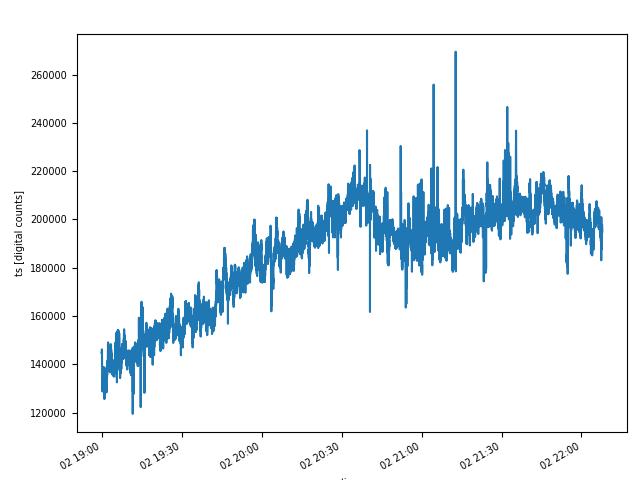

In [55]:
ex._ts.plot.line()
plt.draw()

## Have a look at a run

Let's pick out a run, take a slice of it, and interogate it. There are a couple ways
1. Get a run the first will be from the `run_hdf5_reference` [*demonstrated here*]
2. Get a run from `mth5_object`
3. Get a station first then get a run

In [57]:
run_from_reference = mth5_object.from_reference(ch_df.iloc[0].run_hdf5_reference).to_runts(start=ch_df.iloc[0].start.isoformat(), n_samples=360)
print(run_from_reference)

RunTS Summary:
	Station:     CAS04
	Run:         a
	Start:       2020-06-02T19:00:00+00:00
	End:         2020-06-02T19:06:00+00:00
	Sample Rate: 1.0
	Components:  ['ex', 'ey', 'hx', 'hy', 'hz']


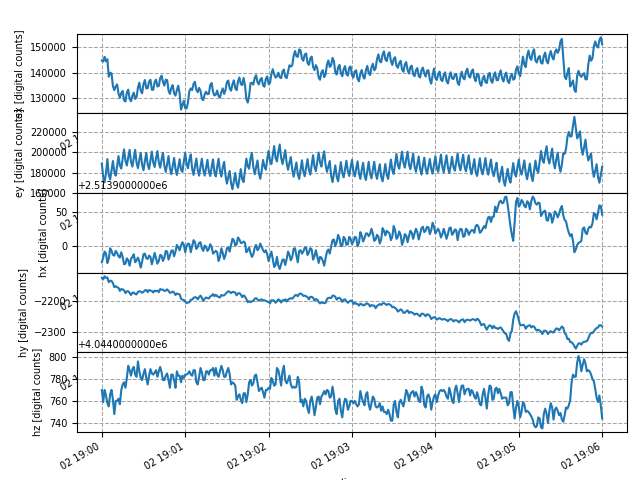

In [58]:
run_from_reference.plot()

## Load Transfer Functions

You can download the transfer functions for **CAS04** and **NVR08** from [IRIS SPUD EMTF](http://ds.iris.edu/spud/emtf).  This has already been done as EMTF XML format and will be loaded here. 

In [5]:
cas04_tf = r"USMTArray.CAS04.2020.xml"
nvr08_tf = r"USMTArray.NVR08.2020.xml"

In [6]:
from mt_metadata.transfer_functions.core import TF

In [7]:
for tf_fn in [cas04_tf, nvr08_tf]:
    mth5_object.add_transfer_function(TF(tf_fn))

### Have a look at the transfer function summary

In [8]:
mth5_object.tf_summary.summarize()
tf_df = mth5_object.tf_summary.to_dataframe()
tf_df

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,CAS04,CONUS_South,37.633351,-121.468382,329.387,CAS04,none,True,True,True,4.65455,29127.11,<HDF5 object reference>,<HDF5 object reference>
1,NVR08,CONUS_South,38.326630,-118.082382,1375.425,NVR08,none,True,True,True,4.65455,29127.11,<HDF5 object reference>,<HDF5 object reference>


### Plot the transfer functions using MTpy

**Note:** This currently works on branch `mtpy/v2_plots`

In [9]:
from mtpy import MTCollection

2022-04-12T18:51:40 [line 96] mtpy.utils.mtpy_decorator._check_gdal_data - WARNING: GDAL_DATA environment variable is not set  Please see https://trac.osgeo.org/gdal/wiki/FAQInstallationAndBuilding#HowtosetGDAL_DATAvariable 
2022-04-12T18:51:40 [line 100] mtpy.utils.mtpy_decorator._check_gdal_data - INFO: Trying to find gdal-data path ...
Ignore GDAL as it is not working. Will use pyproj


2022-04-12 18:51:40,958 [line 135] matplotlib.get_mtpy_logger - INFO: Logging file can be found C:\Users\jpeacock\Documents\GitHub\mtpy\logs\matplotlib_warn.log


2022-04-12T18:51:41 [line 57] rasterio.env.<module> - INFO: failed to import boto3, continuing.


C:\Users\jpeacock\Anaconda3\envs\mt\lib\_collections_abc.py:720: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  yield from self._mapping
C:\Users\jpeacock\Documents\GitHub\mtpy\mtpy\imaging\mtcolors.py:284: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  cmapdict.update(cm.cmap_d)


In [10]:
mc = MTCollection()
mc.open_collection(r"8P_CAS04_NVR08")

C:\Users\jpeacock\Documents\GitHub\mtpy\mtpy\imaging\plot_mt_response.py:420: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  self.fig.clf()
C:\Users\jpeacock\Documents\GitHub\mtpy\mtpy\imaging\plot_mt_response.py:420: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  self.fig.clf()


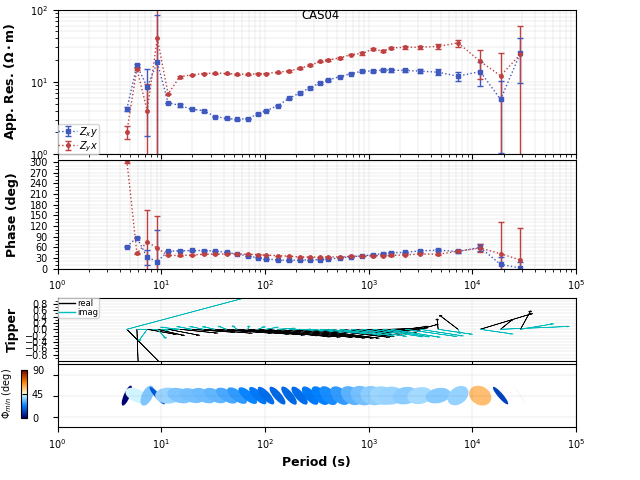

C:\Users\jpeacock\Documents\GitHub\mtpy\mtpy\imaging\plot_mt_response.py:420: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  self.fig.clf()
C:\Users\jpeacock\Documents\GitHub\mtpy\mtpy\imaging\plot_mt_response.py:420: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  self.fig.clf()


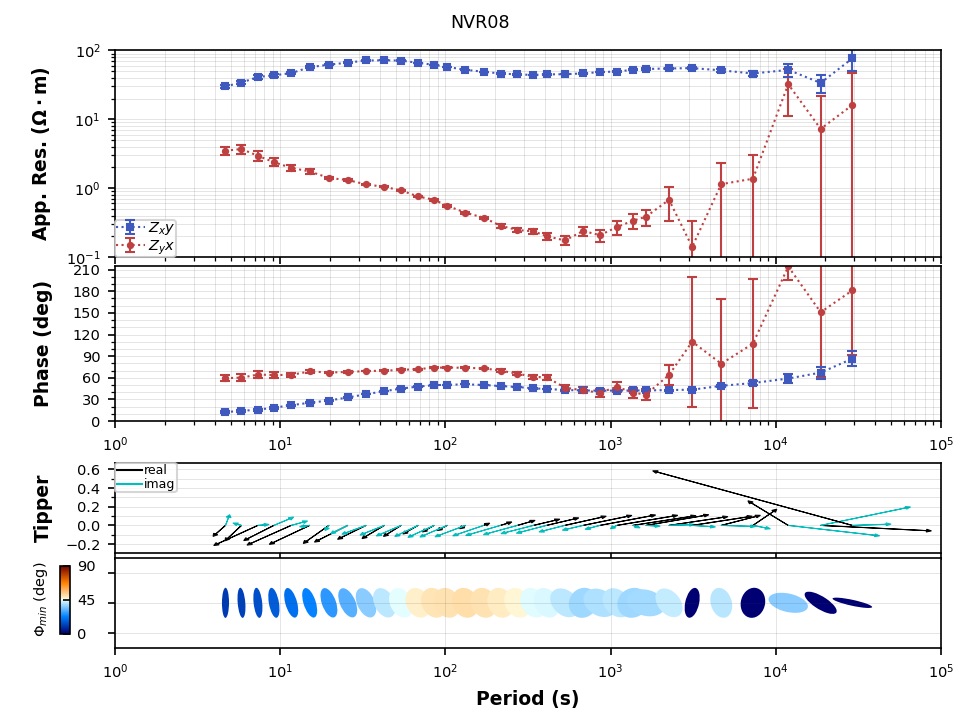

In [37]:
pmr = mc.plot_mt_response(["CAS04", "NVR08"], plot_style="1")

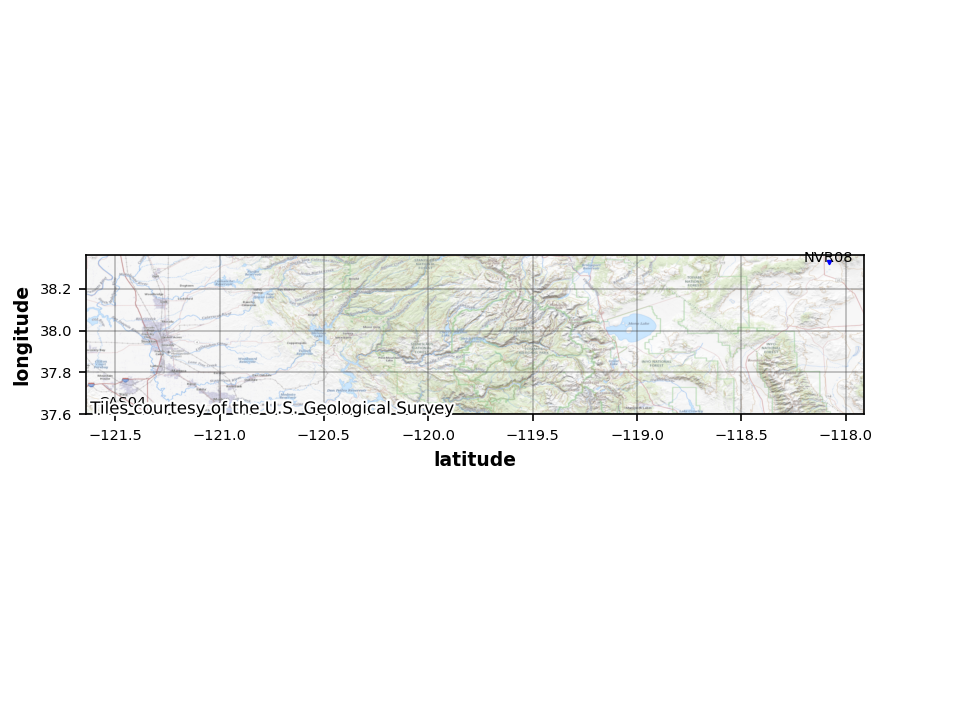

In [32]:
st = mc.plot_stations(pad=.9, fig_num=5)

In [36]:
st.fig.get_axes()[0].set_xlim((-121.9, -117.75))
st.fig.get_axes()[0].set_ylim((37.35, 38.5))
st.update_plot()

In [59]:
mth5_object.close_mth5()

2022-04-12 19:20:08,964 [line 731] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing 8P_CAS04_NVR08.h5
